In [1]:
import re
import nltk
import spacy
import gensim
import itertools

from nltk import ngrams
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Importing model architecture
from siamese_network_model_architecture import Encoder, SiameseNetwork

C:\Users\solom\.conda\envs\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
# Cast to GPU if not it will be processed with CPU
device = torch.device('cuda')

In [4]:
df = pd.read_csv('../0. Sample Datasets/quora_question_pair_sample.csv')

C:\Users\solom\AppData\Local\Temp\ipykernel_19128\858636.py:1: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../0. Sample Datasets/quora_question_pair_sample.csv')


In [5]:
pd.set_option('display.max_column', None) 
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0.0,1.0,2.0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0.0
1,1.0,3.0,4.0,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0.0
2,2.0,5.0,6.0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0.0
3,3.0,7.0,8.0,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0.0
4,4.0,9.0,10.0,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0.0


---
For CosineSimilarity in Pytorch, similar tensors are closer to 1 while dissimilar tensors are closer to -1. See "Pytorch CosineSimilarity Score Range.ipnyb" for demonstration.

As such, we need to change the target y from 0 to -1 for dissimilar _(i.e. not(is_duplicate))_ labels.

---

In [6]:
df.is_duplicate = [-1 if i==0 else i for i in df.is_duplicate]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364932 entries, 0 to 364931
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            100001 non-null  float64
 1   qid1          100001 non-null  float64
 2   qid2          100001 non-null  float64
 3   question1     100001 non-null  object 
 4   question2     100001 non-null  object 
 5   is_duplicate  100001 non-null  float64
dtypes: float64(4), object(2)
memory usage: 16.7+ MB


In [8]:
df[df.question1.isnull()].head()

,id,qid1,qid2,question1,question2,is_duplicate
100001,NaN,NaN,NaN,NaN,NaN,NaN
100002,NaN,NaN,NaN,NaN,NaN,NaN
100003,NaN,NaN,NaN,NaN,NaN,NaN
100004,NaN,NaN,NaN,NaN,NaN,NaN
100005,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df[df.question2.isnull()].head()

,id,qid1,qid2,question1,question2,is_duplicate
100001,NaN,NaN,NaN,NaN,NaN,NaN
100002,NaN,NaN,NaN,NaN,NaN,NaN
100003,NaN,NaN,NaN,NaN,NaN,NaN
100004,NaN,NaN,NaN,NaN,NaN,NaN
100005,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.dropna(axis=0, how='any', inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100001 entries, 0 to 100000
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            100001 non-null  float64
 1   qid1          100001 non-null  float64
 2   qid2          100001 non-null  float64
 3   question1     100001 non-null  object 
 4   question2     100001 non-null  object 
 5   is_duplicate  100001 non-null  float64
dtypes: float64(4), object(2)
memory usage: 5.3+ MB


In [12]:
df.is_duplicate.value_counts()

-1.0    62747
 1.0    37254
Name: is_duplicate, dtype: int64

## We will clean all data (regardless of test/val/train) with the same process before proceeding

**_Will not be removing stopwords as stop words like "how"/"what", etc is important in differentiating the nature of the question_**

In [13]:
lem = nltk.WordNetLemmatizer()

def preprocessing(sentence):
    sent = sentence.lower()
    
    # Removing selected symbols, keeping numbers
    sent = re.sub("\(|\)|\/|\-|\#|\!|\?|\.|\,|\"|\'|\*|\[|\]|\{|\}|\$", "", sent)
    
    # Removing emails
    sent = re.sub("\S*@\S*\s?", "", sent)
    
    # Removing numbers
    sent = re.sub("\d+", "", sent)
    
    return sent

In [14]:
print('What is the step by step guide to invest in share market in india?')

What is the step by step guide to invest in share market in india?


In [15]:
preprocessing('What is the step by step guide to invest in share market in india?')

'what is the step by step guide to invest in share market in india'

In [16]:
preprocessing('How can I know who logged in to my Gmail account? (by telling his IP address or device name)?')

'how can i know who logged in to my gmail account by telling his ip address or device name'

In [17]:
preprocessing("How do I log out of my Gmail account on my friend's phone?")

'how do i log out of my gmail account on my friends phone'

## Split data

In [18]:
X = df.drop('is_duplicate', axis=1)
y = df.is_duplicate

In [19]:
X.head()

,id,qid1,qid2,question1,question2
0,0.0,1.0,2.0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,1.0,3.0,4.0,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,2.0,5.0,6.0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,3.0,7.0,8.0,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,4.0,9.0,10.0,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


In [20]:
y.head()

0   -1.0
1   -1.0
2   -1.0
3   -1.0
4   -1.0
Name: is_duplicate, dtype: float64

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

In [22]:
y_train.value_counts()

-1.0    50197
 1.0    29803
Name: is_duplicate, dtype: int64

In [23]:
y_val.value_counts()

-1.0    6275
 1.0    3725
Name: is_duplicate, dtype: int64

In [24]:
y_test.value_counts()

-1.0    6275
 1.0    3726
Name: is_duplicate, dtype: int64

In [25]:
X_train.head()

,id,qid1,qid2,question1,question2
13341,13341.0,25633.0,18926.0,Can people see I watched their videos while st...,How can I see who views my Instagram?
1534,1534.0,3055.0,3056.0,What are some of the most misheard song lyrics...,What are some of your favorite misheard song l...
7111,7111.0,13903.0,13904.0,How can I stop getting scared?,What is the best way to stop being scared?
7444,7444.0,14543.0,14544.0,Can we kill herpes virus once it is out of ner...,Can we kill herpes virus once it is out of ner...
17564,17564.0,33353.0,33354.0,What are some tips for cleaning eye glasses?,What is the best way to clean a pair of eye gl...


In [26]:
y_train.head()

13341    1.0
1534     1.0
7111     1.0
7444     1.0
17564    1.0
Name: is_duplicate, dtype: float64

In [27]:
# Resetting indexes for subsequent processing (less confusing to tally)
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [28]:
X_train.head()

,id,qid1,qid2,question1,question2
0,13341.0,25633.0,18926.0,Can people see I watched their videos while st...,How can I see who views my Instagram?
1,1534.0,3055.0,3056.0,What are some of the most misheard song lyrics...,What are some of your favorite misheard song l...
2,7111.0,13903.0,13904.0,How can I stop getting scared?,What is the best way to stop being scared?
3,7444.0,14543.0,14544.0,Can we kill herpes virus once it is out of ner...,Can we kill herpes virus once it is out of ner...
4,17564.0,33353.0,33354.0,What are some tips for cleaning eye glasses?,What is the best way to clean a pair of eye gl...


In [29]:
y_train.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: is_duplicate, dtype: float64

## Preprocessing all input text data

In [30]:
X_train['q1_preprocessed'] = [preprocessing(i) for i in X_train.question1]
X_val['q1_preprocessed'] = [preprocessing(i) for i in X_val.question1]
X_test['q1_preprocessed'] = [preprocessing(i) for i in X_test.question1]

X_train['q2_preprocessed'] = [preprocessing(i) for i in X_train.question2]
X_val['q2_preprocessed'] = [preprocessing(i) for i in X_val.question2]
X_test['q2_preprocessed'] = [preprocessing(i) for i in X_test.question2]

In [31]:
X_test.head()

,id,qid1,qid2,question1,question2,q1_preprocessed,q2_preprocessed
0,8759.0,17062.0,17063.0,How do I master coding?,What are the most efficient ways to master C++?,how do i master coding,what are the most efficient ways to master c++
1,97940.0,1744.0,162846.0,What do we need to have the best Halloween?,What makes the best Halloween character?,what do we need to have the best halloween,what makes the best halloween character
2,776.0,1547.0,1548.0,How do payroll companies make money?,How companies make money?,how do payroll companies make money,how companies make money
3,96780.0,46490.0,161154.0,What does the '100' emoji generally mean?,How do I encode Emojis?,what does the emoji generally mean,how do i encode emojis
4,58162.0,69333.0,102087.0,What are the best books available for data str...,Books on data structures?,what are the best books available for data str...,books on data structures


In [32]:
# Dropping columns which are no longer needed
X_train.drop(['qid1', 'qid2', 'question1', 'question2'], axis=1, inplace=True)
X_val.drop(['qid1', 'qid2', 'question1', 'question2'], axis=1, inplace=True)
X_test.drop(['qid1', 'qid2', 'question1', 'question2'], axis=1, inplace=True)

In [33]:
X_train.head()

,id,q1_preprocessed,q2_preprocessed
0,13341.0,can people see i watched their videos while st...,how can i see who views my instagram
1,1534.0,what are some of the most misheard song lyrics...,what are some of your favorite misheard song l...
2,7111.0,how can i stop getting scared,what is the best way to stop being scared
3,7444.0,can we kill herpes virus once it is out of ner...,can we kill herpes virus once it is out of ner...
4,17564.0,what are some tips for cleaning eye glasses,what is the best way to clean a pair of eye gl...


## Tokenising input text

In [34]:
def building_vocab(df, columns=None):
    
    assert columns
    
    input_series = []
    
    for column in columns:
        input_series += df[column].tolist()
        
    tokenized = [i.split() for i in input_series]
        
    # Building vocabulary
    unique_words = ['<PAD>', '<UNK>'] + list(set(itertools.chain.from_iterable(tokenized)))
    vocabulary = dict(zip(unique_words, range(len(unique_words))))

    return vocabulary, len(vocabulary)

In [35]:
def tokenizer_padding(input_series, max_len, vocabulary=None):

    assert vocabulary
    
    if type(input_series)!=list:
        try:
            input_series = input_series.tolist()
        except:
            print ("input_series must be list or of type which can be converter to list")
    
    tokenized = [i.split() for i in input_series]
    
    # Encoding and padding
    document = []
    
    for i in tokenized:
        tok_sent = [vocabulary[j] if j in vocabulary else 1 for j in i]
        document.append(tok_sent)
        
    for i in range(len(document)):
        if len(document[i])<=max_len:
            document[i] = [0]*(max_len-len(document[i])) + document[i]
        else:
            document[i] = document[i][-max_len:]
            
    output = [np.array(i) for i in document]

    return np.vstack(output)

In [36]:
# Defining parameters for modeling
max_length = seq_len = n_units = 50
d_features = 32

In [37]:
# Building vocabulary
X_train_vocab, X_train_vocab_size = building_vocab(X_train, columns=['q1_preprocessed', 'q2_preprocessed'])

In [38]:
X_train_vocab

{'<PAD>': 0,
 '<UNK>': 1,
 '“free”': 2,
 'consequence': 3,
 'lowered': 4,
 'weighlifiting': 5,
 'spout': 6,
 'madonna': 7,
 'marries': 8,
 'affect': 9,
 'auburn': 10,
 'inferiors': 11,
 'governments': 12,
 'aviations': 13,
 'uid': 14,
 'banksys': 15,
 'guile': 16,
 'connector': 17,
 'mere': 18,
 'citytownstate': 19,
 'substances': 20,
 'ren': 21,
 'remarkably': 22,
 'dasavathara': 23,
 'formsservices': 24,
 'ibirité': 25,
 'tombstone': 26,
 'iirc': 27,
 'upperbound': 28,
 'nested': 29,
 'recieve': 30,
 'activia': 31,
 'disordered': 32,
 'conceal': 33,
 'smallest': 34,
 'interphase': 35,
 'coexisted': 36,
 'heartland': 37,
 'paypal': 38,
 'usps': 39,
 'pygame': 40,
 'directing': 41,
 'terrierborder': 42,
 'uzumaki': 43,
 'landlord': 44,
 'seaplane': 45,
 'abroad:': 46,
 'piano': 47,
 'orthognathic': 48,
 'larg': 49,
 'evaluating': 50,
 'humiliating': 51,
 'rockets': 52,
 'brosnan': 53,
 'podcast': 54,
 'adviser': 55,
 'pitts': 56,
 'work:': 57,
 'muffled': 58,
 'nsaid': 59,
 'reunificat

In [39]:
X_train_anchor_padded_doc= tokenizer_padding(X_train.q1_preprocessed, max_len=max_length, vocabulary=X_train_vocab)
X_val_anchor_padded_doc = tokenizer_padding(X_val.q1_preprocessed, max_len=max_length, vocabulary=X_train_vocab)
X_test_anchor_padded_doc = tokenizer_padding(X_test.q1_preprocessed, max_len=max_length, vocabulary=X_train_vocab)

X_train_comparison_padded_doc= tokenizer_padding(X_train.q2_preprocessed, max_len=max_length, vocabulary=X_train_vocab)
X_val_comparison_padded_doc = tokenizer_padding(X_val.q2_preprocessed, max_len=max_length, vocabulary=X_train_vocab)
X_test_comparison_padded_doc = tokenizer_padding(X_test.q2_preprocessed, max_len=max_length, vocabulary=X_train_vocab)

### Validating data sequence and pairs

In [40]:
X_train_anchor_padded_doc[:1]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,  3464, 28409, 13598,  3241, 37736, 18760,  6044,
        31171, 33172,  6953, 45036,  7328]])

In [41]:
X_train_comparison_padded_doc[:1]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,  2928,  3464,  3241,
        13598, 17921,  3325, 40930,  7328]])

In [42]:
X_train.iloc[0,:]

id                                                           13341.0
q1_preprocessed    can people see i watched their videos while st...
q2_preprocessed                 how can i see who views my instagram
Name: 0, dtype: object

In [43]:
X_train.iloc[0,:]['q1_preprocessed']

'can people see i watched their videos while stalking them on instagram'

In [44]:
X_train.iloc[0,:]['q2_preprocessed']

'how can i see who views my instagram'

In [45]:
a = tokenizer_padding([X_train.iloc[0,:]['q1_preprocessed']], max_len=max_length, vocabulary=X_train_vocab)
b = tokenizer_padding([X_train.iloc[0,:]['q2_preprocessed']], max_len=max_length, vocabulary=X_train_vocab)

In [46]:
a

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,  3464, 28409, 13598,  3241, 37736, 18760,  6044,
        31171, 33172,  6953, 45036,  7328]])

In [47]:
b

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,  2928,  3464,  3241,
        13598, 17921,  3325, 40930,  7328]])

In [48]:
y_train[0]

1.0

In [49]:
df[df.id==386274]

,id,qid1,qid2,question1,question2,is_duplicate


## Preparing data for training

In [50]:
# Convert list to tensors
train_X_anchor = torch.tensor(X_train_anchor_padded_doc)
train_X_comparison = torch.tensor(X_train_comparison_padded_doc)
train_y = torch.tensor(y_train.astype(float))

test_X_anchor = torch.tensor(X_test_anchor_padded_doc)
test_X_comparison = torch.tensor(X_test_comparison_padded_doc)
test_y = torch.tensor(y_test.astype(float))

val_X_anchor = torch.tensor(X_val_anchor_padded_doc)
val_X_comparison = torch.tensor(X_val_comparison_padded_doc)
val_y = torch.tensor(y_val.astype(float))

In [51]:
# Define batch size
batch_size = 64

# FOR TRAINING
# Wrap tensors
train_data = TensorDataset(train_X_anchor, train_X_comparison, train_y)

# Sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# Dataloader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)



# FOR VALIDATING
# Wrap tensors
val_data = TensorDataset(val_X_anchor, val_X_comparison, val_y)

# Sampler for sampling the data during validation for training
val_sampler = SequentialSampler(val_data)

# Dataloader for val set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## Modeling without class balancing?

In [52]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('D:\DSAI\Pre-Trained Models\word2vec\GoogleNews-vectors-negative300.bin.gz', binary=True)

In [53]:
# Getting embedding matrix for pre-trained Word2Vec model
embeddings_index = dict()

# We will populate the embeddings_index dictionary with all the key<->vector pairs in the Word2Vec model
for line in range(len(w2v_model.index_to_key)):
    embeddings_index[w2v_model.index_to_key[line]] = w2v_model.get_vector(w2v_model.index_to_key[line])
    
# Create a weight matrix for words in training docs
embedding_matrix = np.zeros((X_train_vocab_size, 300)) # Change X_train_vocab_size
for word, i in X_train_vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(47074, 300)

In [54]:
X_train_vocab_size

47074

## Defining model

In [55]:
# Defining parameters for modeling
max_length = seq_len = n_units = 50
d_features = 32

In [56]:
embedding_matrix.shape

(47074, 300)

In [57]:
encoder = Encoder(input_size=X_train_vocab_size,
                  embedding_size=embedding_matrix.shape[1], 
                  embedding_matrix=embedding_matrix, 
                  hidden_size=20, 
                  num_layers=1, 
                  dropout=0.2)

C:\Users\solom\.conda\envs\nlp\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [58]:
# encoder = Encoder(input_size=X_train_vocab_size,
#                   embedding_size=5, 
#                   embedding_matrix=None, 
#                   hidden_size=5, 
#                   num_layers=1, 
#                   dropout=0.5)

In [59]:
model = SiameseNetwork(encoder=encoder)

In [60]:
print (model)

SiameseNetwork(
  (encoder): Encoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (embedding): Embedding(47074, 300, padding_idx=0)
    (lstm): LSTM(300, 20, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (cosinesimilarity): CosineSimilarity()
)


In [61]:
model = model.to(device)

In [62]:
from torch.optim import AdamW

# Define optimiser
optimizer = AdamW(model.parameters(), lr=2e-3)

In [63]:
y_train.value_counts()

-1.0    50197
 1.0    29803
Name: is_duplicate, dtype: int64

In [64]:
weight = np.array(y_train.value_counts()[-1]/y_train.value_counts()[1])

In [65]:
weight

array(1.68429353)

In [66]:
# Converting list of class weights to a tensor
weights = torch.tensor(weight, dtype=torch.float)

# Push weights to GPU
weights = weights.to(device)

# Define loss function
cross_entropy = nn.BCEWithLogitsLoss(pos_weight=weights)

# No of training epochs
epochs = 10

## Define Training & Evaluation Functions

In [67]:
def train():
    model.train()
    
    total_loss, total_accuracy = 0, 0
    
    # Empty list to save model predictions
    total_preds = []
    
    # Iterate over batches
    for step, batch in enumerate(train_dataloader):
        # Progress update for every 50 batches
        if step%50==0 and not step==0:
            print ('Batch {:>5,} of {:>5,}.'.format(step, len(train_dataloader)))
            
        # Push batch to GPU
        batch = [r.to(device) for r in batch]
        
        anchor_sent, comparison_sent, labels = batch

        # Clear previously calculated gradients
        model.zero_grad()
        
        # Get model predictions for the current batch
        preds = model(anchor_sent, comparison_sent)
        
        # Compute loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        
        # Add on to the total loss
        total_loss = total_loss + loss.item()
        
        # Backward pass to calculate gradients
        loss.backward()
        
        # Clip gradients to 1.0. It helps in preventing exploding gradient problem
        torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)
        
        # Update parameters
        optimizer.step()
        
        # Model predictions are stored on GPU, so push it to CPU
        preds = preds.detach().cpu().numpy()
        
        # Append model predictions
        total_preds.append(preds)
        
    # Compute training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    
    # Predictions are in the form of (no. of batches, size of batch, no of classes)
    # Reshape the prediction in form of (no of samples, no of classes)
    total_preds = np.concatenate(total_preds, axis=0)
    
    return avg_loss, total_preds

In [68]:
def evaluate():
    print ('\nEvaluating...')
    
    # Deactivate dropout layers
    model.eval()
    
    total_loss, total_accuracy = 0, 0
    
    # Empty list to save model predictions
    total_preds = []
    
    # Iterate over batches
    for step, batch in enumerate(val_dataloader):
        # Progress update for every 50 batches
        if step%50==0 and not step==0:
            print ('Batch {:>5,} of {:>5,}.'.format(step, len(val_dataloader)))
            
        # Push batch to GPU
        batch = [t.to(device) for t in batch]
        
        anchor_sent, comparison_sent, labels = batch
        
        # Deactivate autograd()
        with torch.no_grad():
            
            # Model predictions
            preds = model(anchor_sent, comparison_sent)
            
            # Compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)
            
            total_loss = total_loss + loss.item()
            
            preds = preds.detach().cpu().numpy()
            
            total_preds.append(preds)
            
    # Compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)
    
    # Reshape the predictions in form of (no of samples, no of classes)
    total_preds = np.concatenate(total_preds, axis=0)
    
    return avg_loss, total_preds

## Iterate through training loop

In [69]:
# Set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

# For each epoch
for epoch in range(epochs):
    print ('\nEpoch {:}/ {:}'.format(epoch+1, epochs))
    
    # Train model
    train_loss, _ = train()
    
    # Evaluate model
    valid_loss, _ = evaluate()
    
    # Save the best model
    if valid_loss<best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_model_weights/pytorch_siamese_network.pt')
        
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print (f"\nTraining Loss: {train_loss:.5f}")
    print (f"Validation Loss: {valid_loss:.5f}")


Epoch 1/ 10


C:\Users\solom\AppData\Local\Temp\ipykernel_19128\3622700757.py:36: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)


Batch    50 of 1,250.
Batch   100 of 1,250.
Batch   150 of 1,250.
Batch   200 of 1,250.
Batch   250 of 1,250.
Batch   300 of 1,250.
Batch   350 of 1,250.
Batch   400 of 1,250.
Batch   450 of 1,250.
Batch   500 of 1,250.
Batch   550 of 1,250.
Batch   600 of 1,250.
Batch   650 of 1,250.
Batch   700 of 1,250.
Batch   750 of 1,250.
Batch   800 of 1,250.
Batch   850 of 1,250.
Batch   900 of 1,250.
Batch   950 of 1,250.
Batch 1,000 of 1,250.
Batch 1,050 of 1,250.
Batch 1,100 of 1,250.
Batch 1,150 of 1,250.
Batch 1,200 of 1,250.

Evaluating...
Batch    50 of   157.
Batch   100 of   157.
Batch   150 of   157.

Training Loss: 0.68217
Validation Loss: 0.70877

Epoch 2/ 10
Batch    50 of 1,250.
Batch   100 of 1,250.
Batch   150 of 1,250.
Batch   200 of 1,250.
Batch   250 of 1,250.
Batch   300 of 1,250.
Batch   350 of 1,250.
Batch   400 of 1,250.
Batch   450 of 1,250.
Batch   500 of 1,250.
Batch   550 of 1,250.
Batch   600 of 1,250.
Batch   650 of 1,250.
Batch   700 of 1,250.
Batch   750 of 1,250.

## Visualise training and validation loss

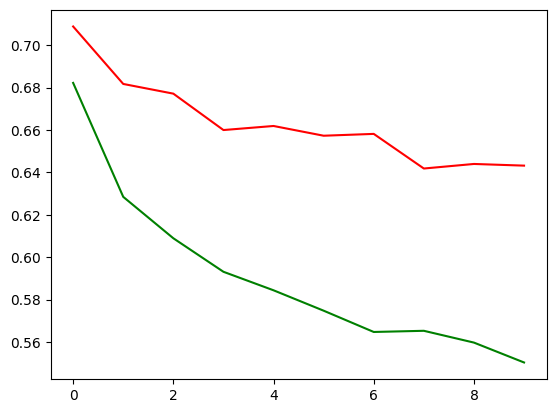

In [70]:
import matplotlib.pyplot as plt
plt.plot(train_losses, 'g', valid_losses, 'r')

## Model evaluation

In [71]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

In [72]:
model_path = 'saved_model_weights/pytorch_siamese_network.pt'

model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [73]:
final_encoder = model.encoder

In [74]:
print (final_encoder)

Encoder(
  (dropout): Dropout(p=0.2, inplace=False)
  (embedding): Embedding(47074, 300, padding_idx=0)
  (lstm): LSTM(300, 20, batch_first=True, dropout=0.2, bidirectional=True)
)


In [75]:
y_test.head()

0   -1.0
1   -1.0
2   -1.0
3   -1.0
4    1.0
Name: is_duplicate, dtype: float64

In [76]:
X_test.head()

,id,q1_preprocessed,q2_preprocessed
0,8759.0,how do i master coding,what are the most efficient ways to master c++
1,97940.0,what do we need to have the best halloween,what makes the best halloween character
2,776.0,how do payroll companies make money,how companies make money
3,96780.0,what does the emoji generally mean,how do i encode emojis
4,58162.0,what are the best books available for data str...,books on data structures


In [77]:
test_X_anchor[:5]

tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,  2928,   107,  3241, 30359, 38384],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0, 35832,   107, 35436, 17033, 43912, 45335, 29489, 32936, 34402],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,

In [78]:
test_X_comparison[:5]

tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0, 35832, 17377, 29489,  6414, 17770, 24659, 43912, 30359, 29935],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0, 35832, 44922, 29489, 32936, 34402, 20948],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,

In [79]:
out_anchor = final_encoder(test_X_anchor[:5].to(device))
out_comparison = final_encoder(test_X_comparison[:5].to(device))

In [80]:
cos = nn.CosineSimilarity(dim=0)

In [81]:
cos(out_anchor[0], out_comparison[0])

tensor(-0.0767, device='cuda:0', grad_fn=<SumBackward1>)

In [82]:
cos(out_anchor[1], out_comparison[1])

tensor(0.1769, device='cuda:0', grad_fn=<SumBackward1>)

In [83]:
cos(out_anchor[2], out_comparison[2])

tensor(-0.3286, device='cuda:0', grad_fn=<SumBackward1>)

In [84]:
cos(out_anchor[3], out_comparison[3])

tensor(-0.2477, device='cuda:0', grad_fn=<SumBackward1>)

In [85]:
cos(out_anchor[4], out_comparison[4])

tensor(0.4378, device='cuda:0', grad_fn=<SumBackward1>)